# Анализ [данных о пингвинах](https://www.kaggle.com/datasets/amulyas/penguin-size-dataset) с построением прогнозных моделей

## **1. Введение**

### **Цели проекта**
1. Провести разведочный анализ данных (EDA) для выявления закономерностей
2. Построить модели классификации видов пингвинов
3. Исследовать данные методами кластеризации
4. Сформулировать биологически значимые выводы


## **2. Загрузка и предварительный анализ**

### **2.1. Импорт библиотек**

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, silhouette_score)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')


### **2.2. Загрузка данных**

In [66]:
penguins = pd.read_csv('penguins_size.csv')
print("Первые 5 строк данных:")
display(penguins.head())

Первые 5 строк данных:


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [67]:
penguins.shape

(344, 7)

In [68]:
penguins['species'].value_counts()

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

### **Вывод**:  
Данные содержат 7 столбцов с морфологическими характеристиками и метками вида.
Представлены измерения 344 пингвинов с островов:
- **Признаки**: морфологические характеристики (клюв, плавники, масса)
- **Целевая переменная**: вид пингвина (Adelie, Chinstrap, Gentoo)


## **3. Разведочный анализ данных (EDA)**

### **3.1. Проверка качества данных**

In [70]:
missing_data = penguins.isnull().sum().to_frame(name='Пропущенные значения')
missing_data['% от общего'] = (missing_data['Пропущенные значения'] / len(penguins)) * 100
display(missing_data)

,Пропущенные значения,% от общего
species,0,0.000000
island,0,0.000000
culmen_length_mm,2,0.581395
culmen_depth_mm,2,0.581395
flipper_length_mm,2,0.581395
body_mass_g,2,0.581395
sex,10,2.906977


### **Заполнение пропущенных значений**

In [72]:
# Для числовых признаков - медиана
numeric_features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
for col in numeric_features:
    penguins[col] = penguins.groupby(['species', 'sex'])[col].transform(lambda x: x.fillna(x.median()))

# Для категориального признака sex - удаление 
penguins.dropna(subset=['sex'], inplace=True)


### **3.2. Визуализация распределений**

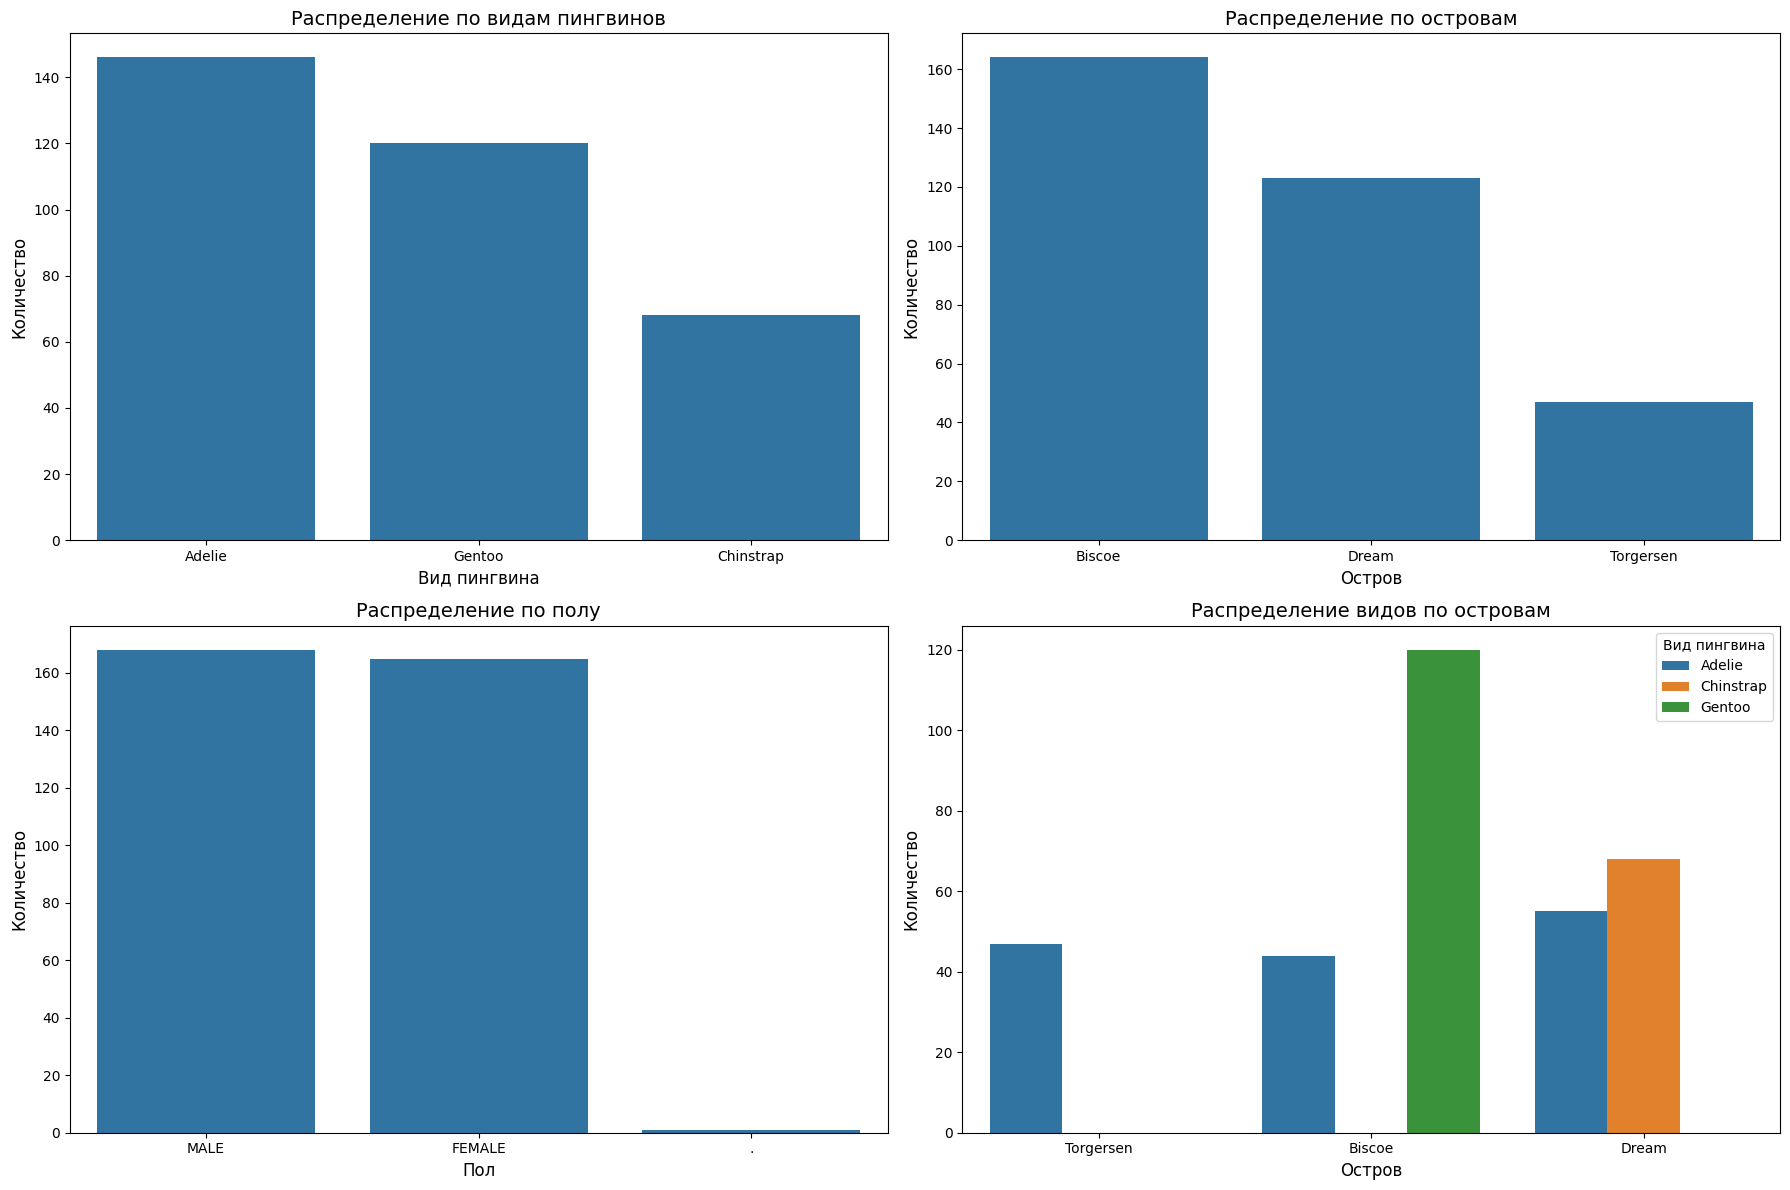

In [74]:
plt.figure(figsize=(18, 12))

# Распределение по видам
plt.subplot(2, 2, 1)
sns.countplot(data=penguins, x='species', order=penguins['species'].value_counts().index)
plt.title('Распределение по видам пингвинов', fontsize=14)
plt.xlabel('Вид пингвина', fontsize=12)
plt.ylabel('Количество', fontsize=12)

# Распределение по островам
plt.subplot(2, 2, 2)
sns.countplot(data=penguins, x='island', order=penguins['island'].value_counts().index)
plt.title('Распределение по островам', fontsize=14)
plt.xlabel('Остров', fontsize=12)
plt.ylabel('Количество', fontsize=12)

# Распределение по полу
plt.subplot(2, 2, 3)
sns.countplot(data=penguins, x='sex')
plt.title('Распределение по полу', fontsize=14)
plt.xlabel('Пол', fontsize=12)
plt.ylabel('Количество', fontsize=12)

# Распределение видов по островам
plt.subplot(2, 2, 4)
sns.countplot(data=penguins, x='island', hue='species')
plt.title('Распределение видов по островам', fontsize=14)
plt.xlabel('Остров', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.legend(title='Вид пингвина')

plt.tight_layout()
plt.show()

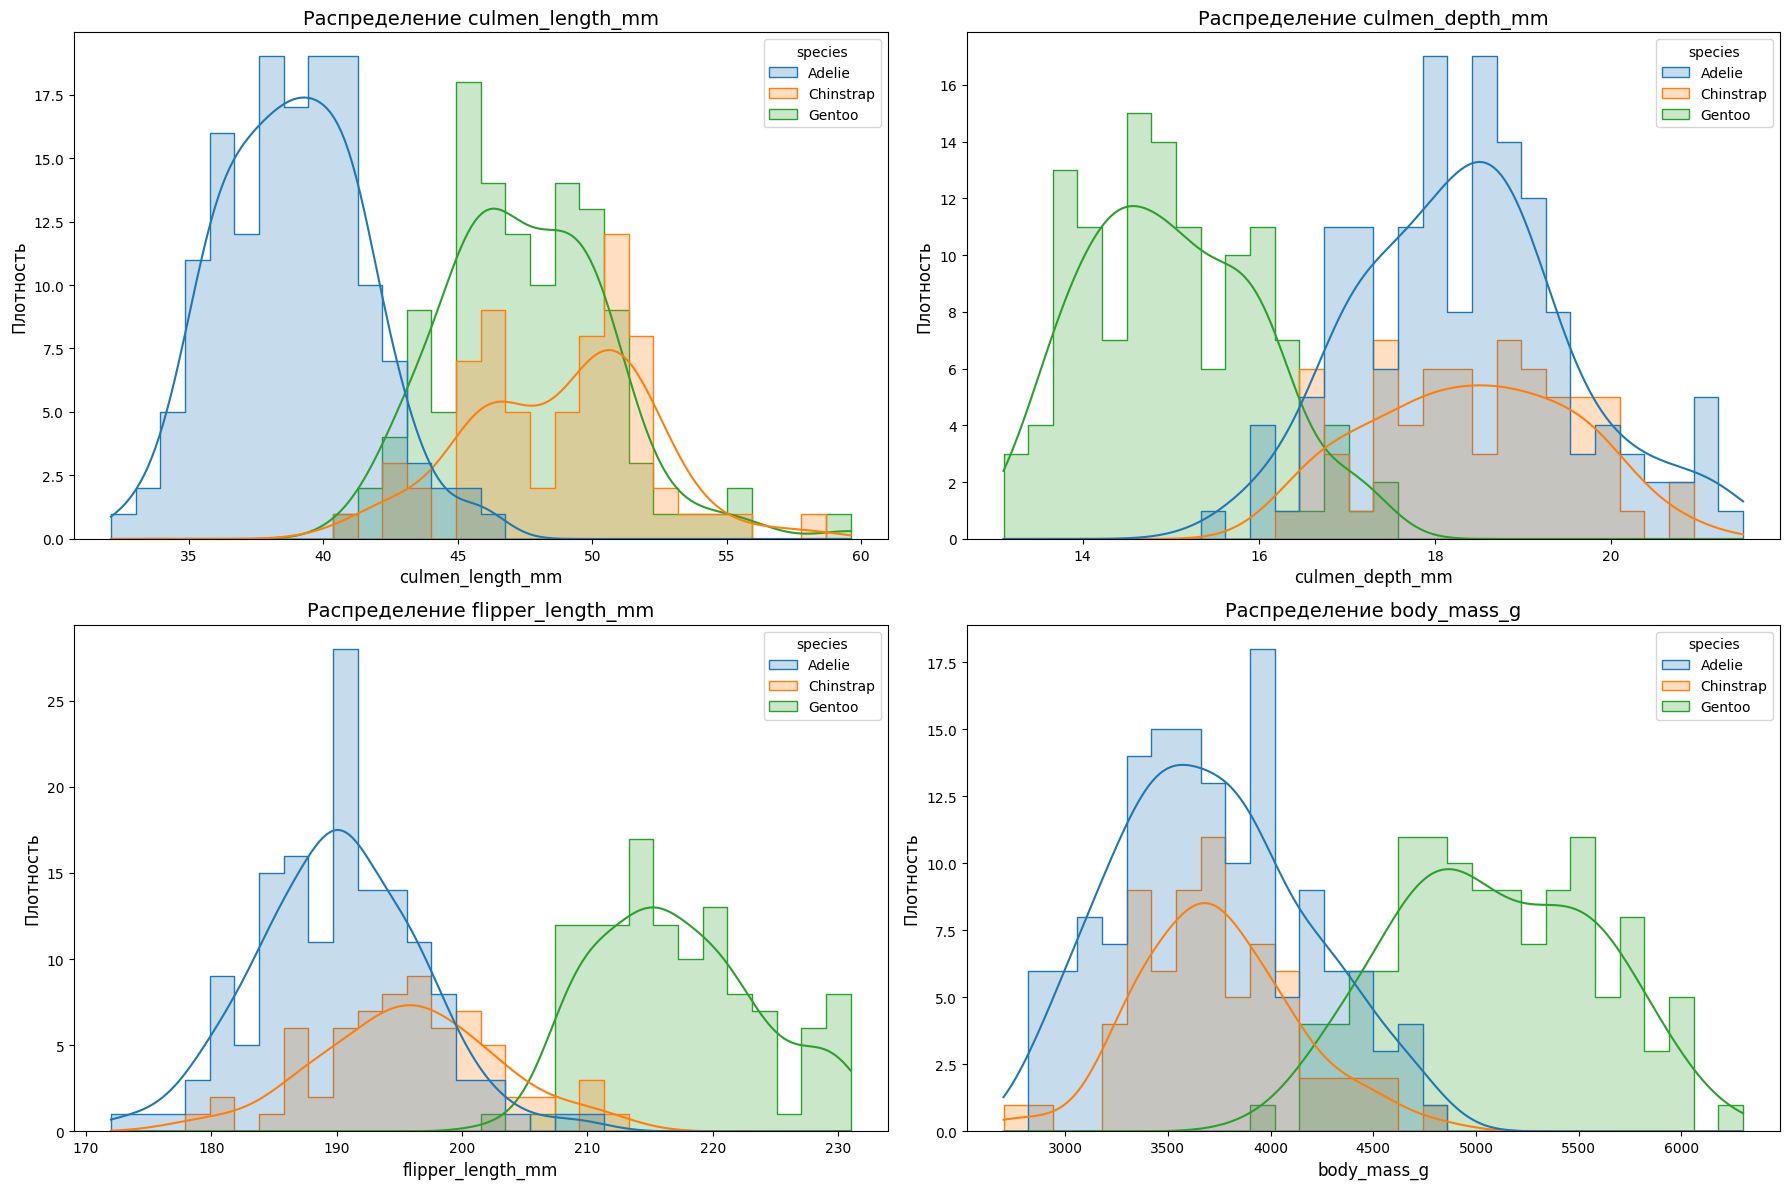

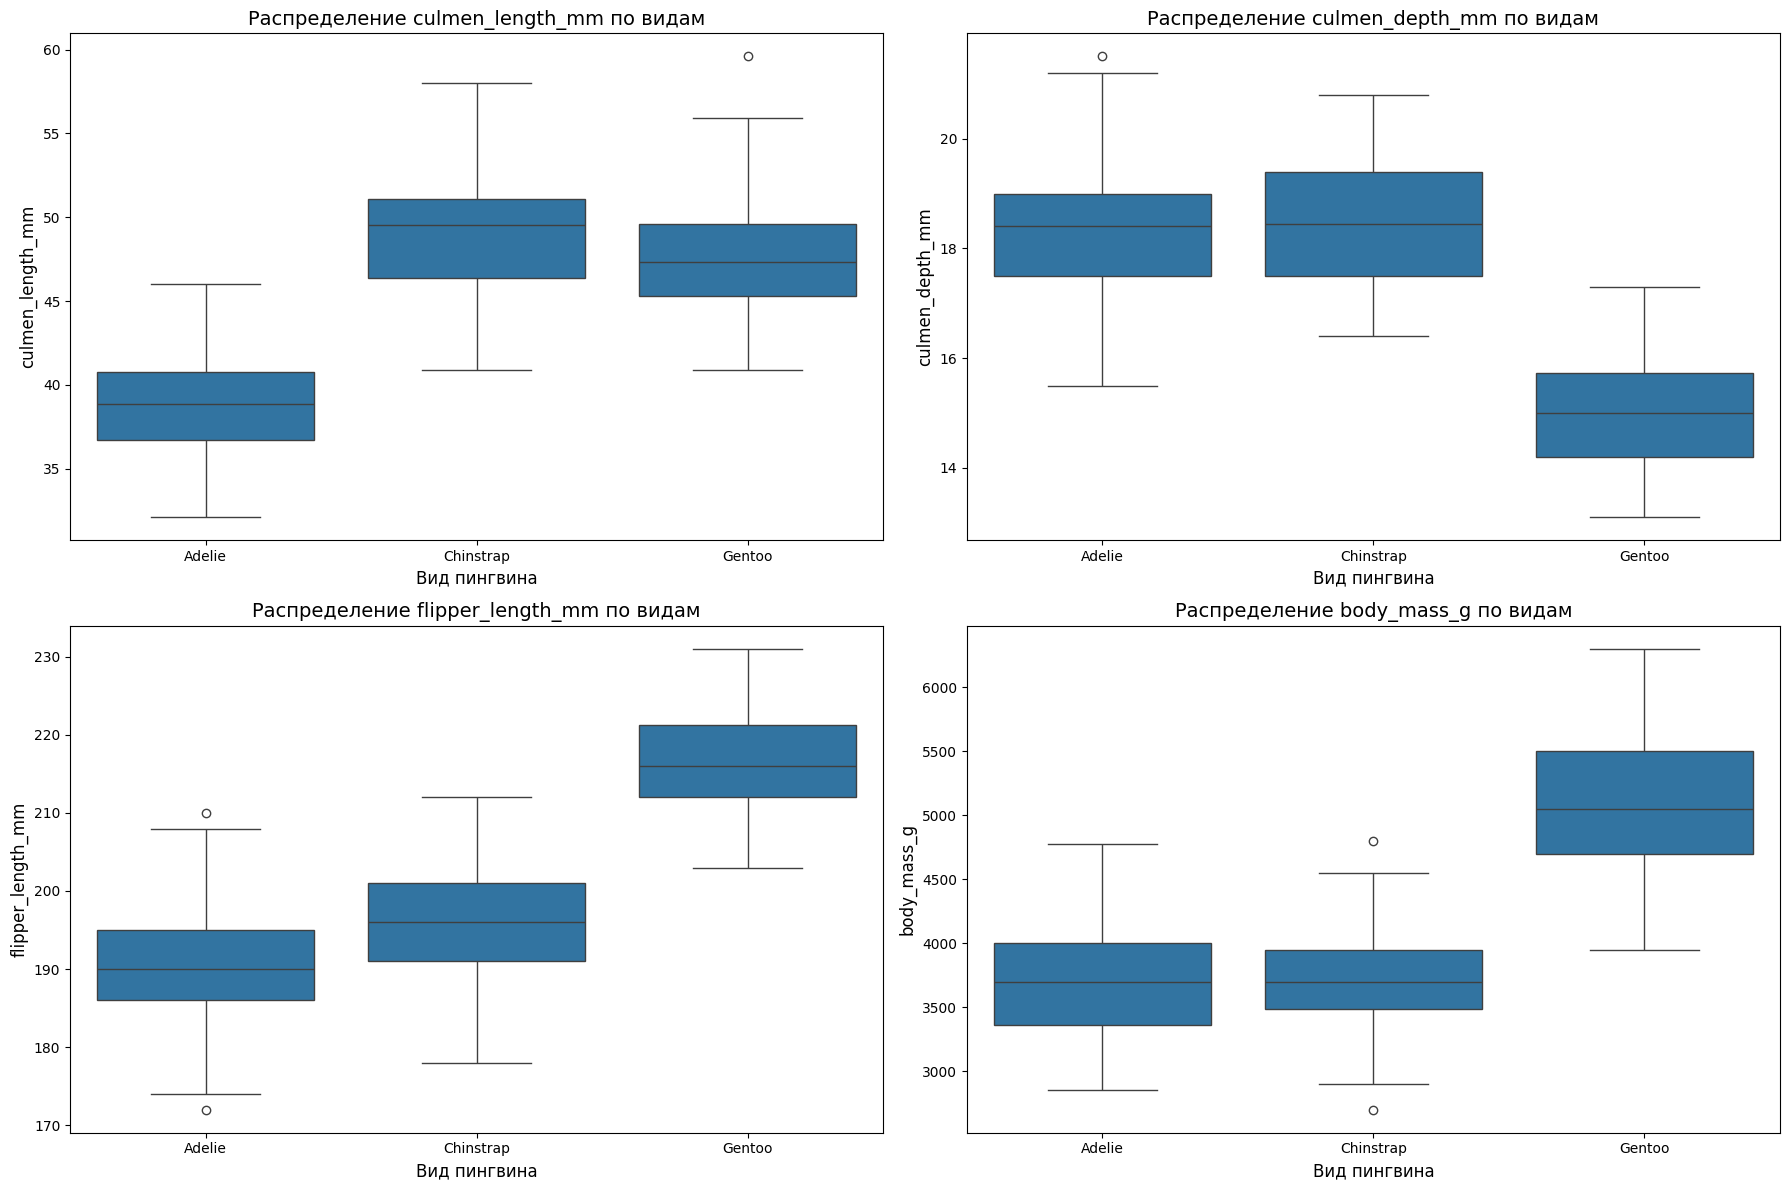

In [75]:
# Распределения числовых признаков
plt.figure(figsize=(18, 12))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data=penguins, x=feature, kde=True, bins=30, hue='species', element='step')
    plt.title(f'Распределение {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Плотность', fontsize=12)
plt.tight_layout()
plt.show()

# Boxplot для числовых признаков по видам
plt.figure(figsize=(18, 12))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=penguins, x='species', y=feature)
    plt.title(f'Распределение {feature} по видам', fontsize=14)
    plt.xlabel('Вид пингвина', fontsize=12)
    plt.ylabel(feature, fontsize=12)
plt.tight_layout()
plt.show()

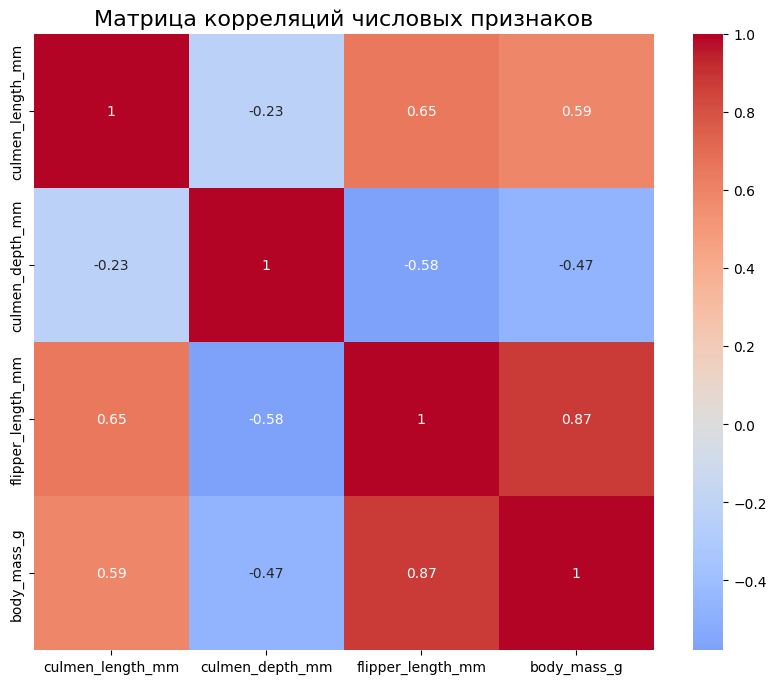

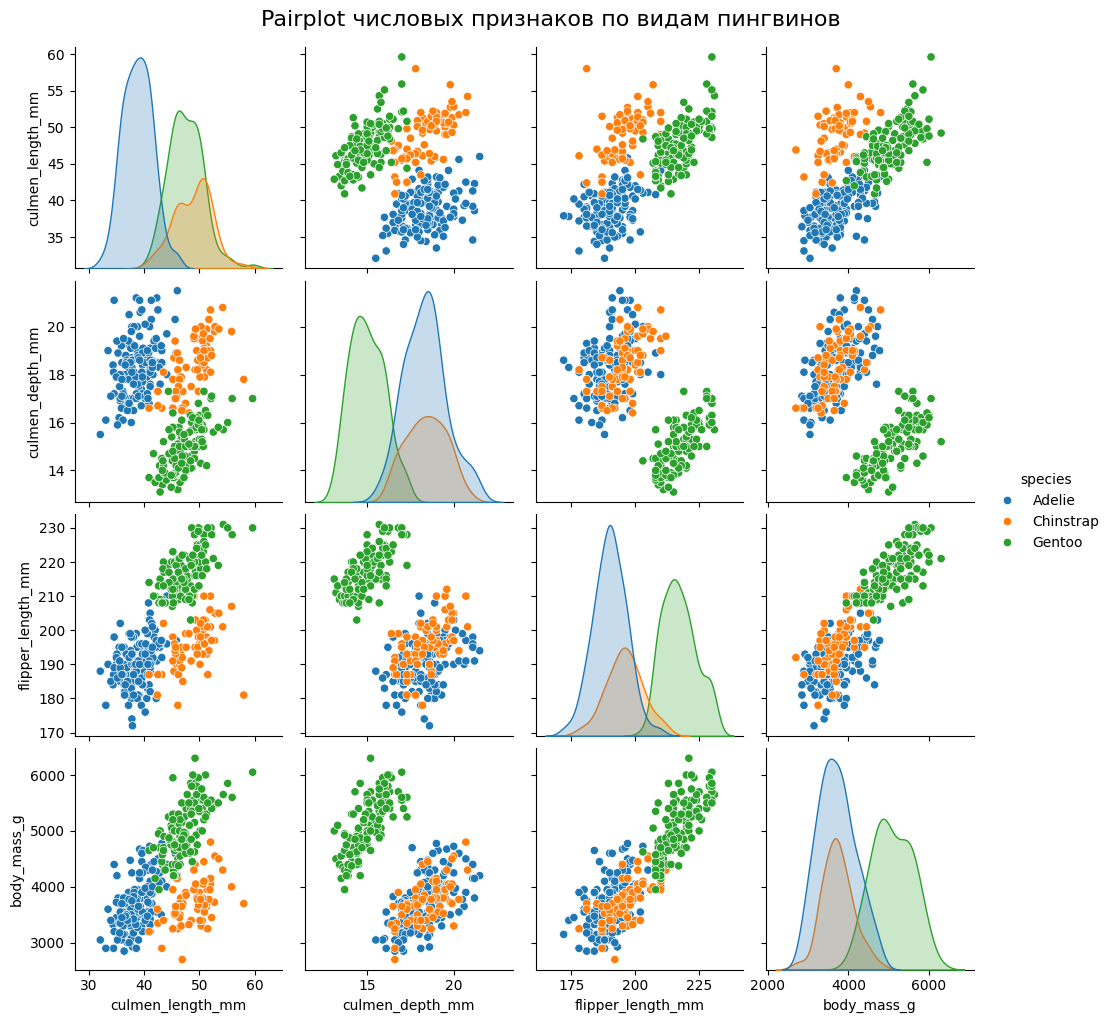

In [76]:
# Матрица корреляций
plt.figure(figsize=(10, 8))
corr_matrix = penguins[numeric_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляций числовых признаков', fontsize=16)
plt.show()

# Pairplot с разбивкой по видам
sns.pairplot(penguins, hue='species', vars=numeric_features, diag_kind='kde')
plt.suptitle('Pairplot числовых признаков по видам пингвинов', y=1.02, fontsize=16)
plt.show()

### **Вывод**
Как видно из графиков, распределение по островам довольно информативно, можно точно разделить два вида пингвинов (Chinstrap и Gentoo). Так же масса помогает выделить определённый вид (Gentoo). А наименее коррелированными, значит наиболее полезными, признаками являются длина и ширина клюва.

## **4. Классификация видов пингвинов**

### **4.1. Подготовка данных**

In [79]:
# Кодирование категориальных признаков
le = LabelEncoder()
penguins['species_encoded'] = le.fit_transform(penguins['species'])
le2 = LabelEncoder()
penguins['island_encoded'] = le2.fit_transform(penguins['island'])
le3 = LabelEncoder()
penguins['sex_encoded'] = le3.fit_transform(penguins['sex'])

# Разделение на признаки и целевую переменную
X = penguins[['island_encoded', 'culmen_length_mm', 'culmen_depth_mm', 
              'flipper_length_mm', 'body_mass_g', 'sex_encoded']]
y = penguins['species_encoded']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### **4.2. Логистическая регрессия**

Оценка качества логистической регрессии:
Accuracy: 1.0
Precision (macro): 1.0
Recall (macro): 1.0
F1-score (macro): 1.0

Classification Report:
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        44
   Chinstrap       1.00      1.00      1.00        21
      Gentoo       1.00      1.00      1.00        36

    accuracy                           1.00       101
   macro avg       1.00      1.00      1.00       101
weighted avg       1.00      1.00      1.00       101



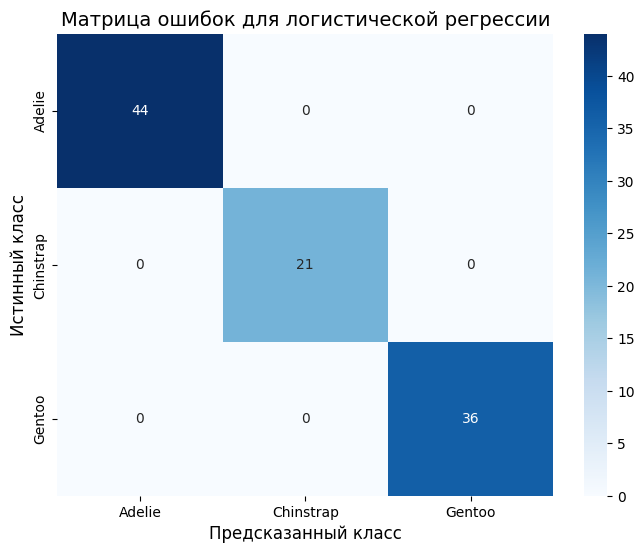

In [81]:
# Создание и обучение модели
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Предсказания
y_pred_log = log_reg.predict(X_test_scaled)

# Оценка качества
print("Оценка качества логистической регрессии:")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Precision (macro):", precision_score(y_test, y_pred_log, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_log, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_pred_log, average='macro'))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_log, target_names=le.classes_))

# Матрица ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt='d', 
            cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Матрица ошибок для логистической регрессии', fontsize=14)
plt.xlabel('Предсказанный класс', fontsize=12)
plt.ylabel('Истинный класс', fontsize=12)
plt.show()

**Результат**:  
Accuracy = 1 - модель отлично справляется с классификацией.

### **4.3. Метод k-ближайших соседей (kNN)**

Оптимальное количество соседей: 9

Оценка качества kNN:
Accuracy: 1.0
Precision (macro): 1.0
Recall (macro): 1.0
F1-score (macro): 1.0

Classification Report:
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        44
   Chinstrap       1.00      1.00      1.00        21
      Gentoo       1.00      1.00      1.00        36

    accuracy                           1.00       101
   macro avg       1.00      1.00      1.00       101
weighted avg       1.00      1.00      1.00       101



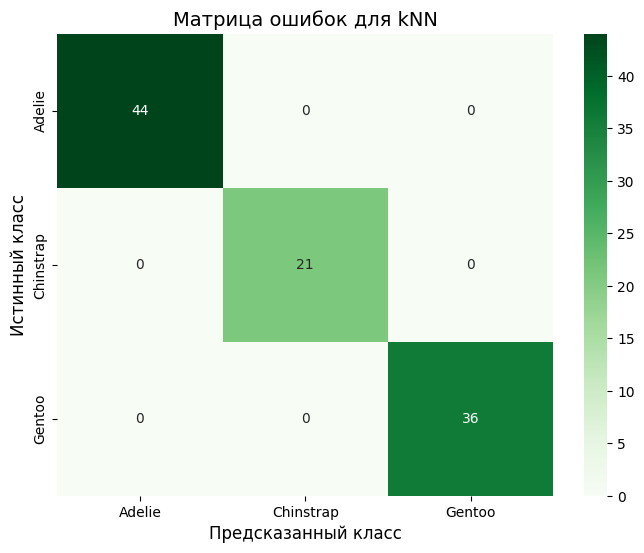

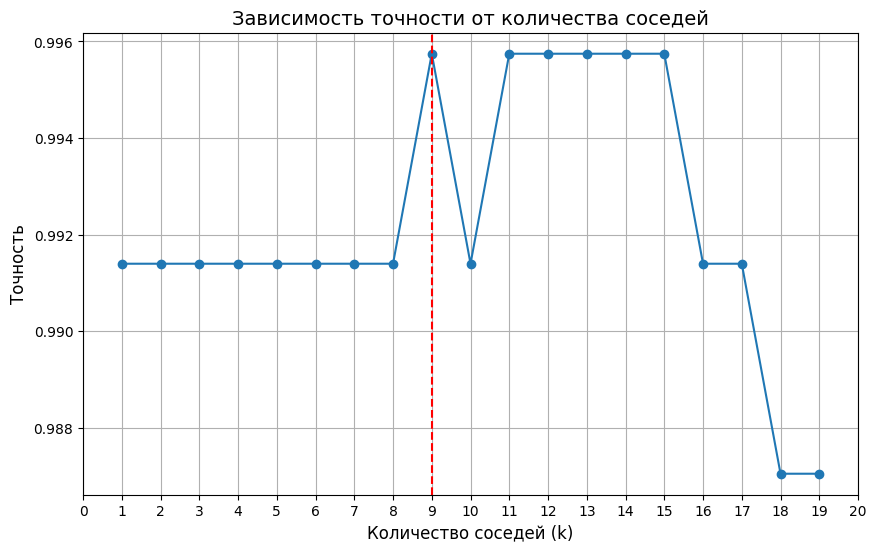

In [84]:
# Подбор оптимального k с помощью GridSearchCV
param_grid = {'n_neighbors': range(1, 20)}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Лучшие параметры
best_k = grid_search.best_params_['n_neighbors']
print(f"Оптимальное количество соседей: {best_k}")

# Обучение модели с оптимальным k
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)

# Предсказания
y_pred_knn = knn.predict(X_test_scaled)

# Оценка качества
print("\nОценка качества kNN:")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Precision (macro):", precision_score(y_test, y_pred_knn, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_knn, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_pred_knn, average='macro'))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn, target_names=le.classes_))

# Матрица ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', 
            cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Матрица ошибок для kNN', fontsize=14)
plt.xlabel('Предсказанный класс', fontsize=12)
plt.ylabel('Истинный класс', fontsize=12)
plt.show()

# График зависимости точности от количества соседей
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), grid_search.cv_results_['mean_test_score'], marker='o')
plt.axvline(x=best_k, color='r', linestyle='--')
plt.title('Зависимость точности от количества соседей', fontsize=14)
plt.xlabel('Количество соседей (k)', fontsize=12)
plt.ylabel('Точность', fontsize=12)
plt.xticks(np.arange(0, 21)) 
plt.grid(True)
plt.show()

**Оптимизация**:  
С помощью GridSearchCV мы смогли найти оптимальное количество соседей k=9.

## **5. Кластеризация данных**

### **5.1. Метод K-средних**

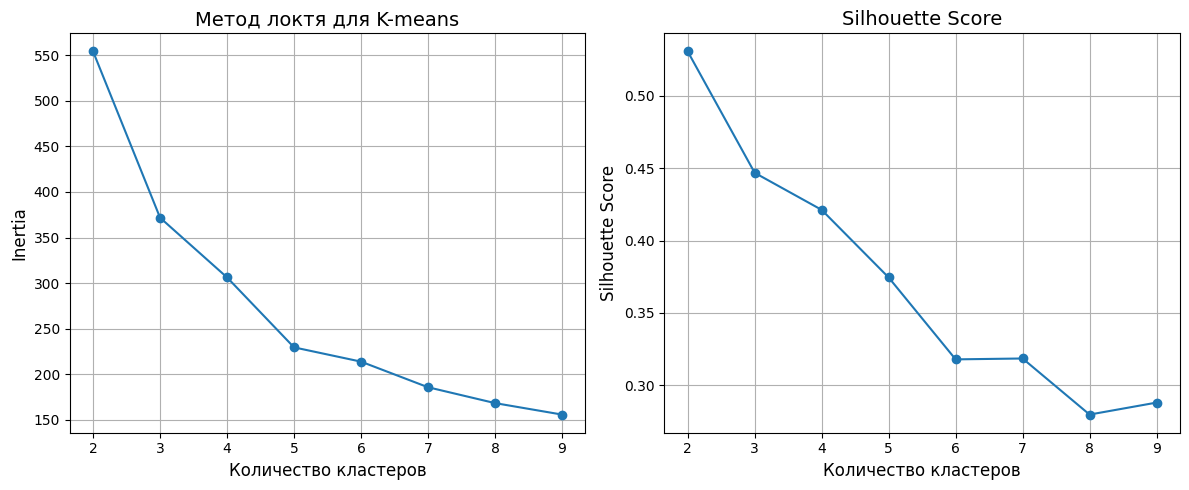

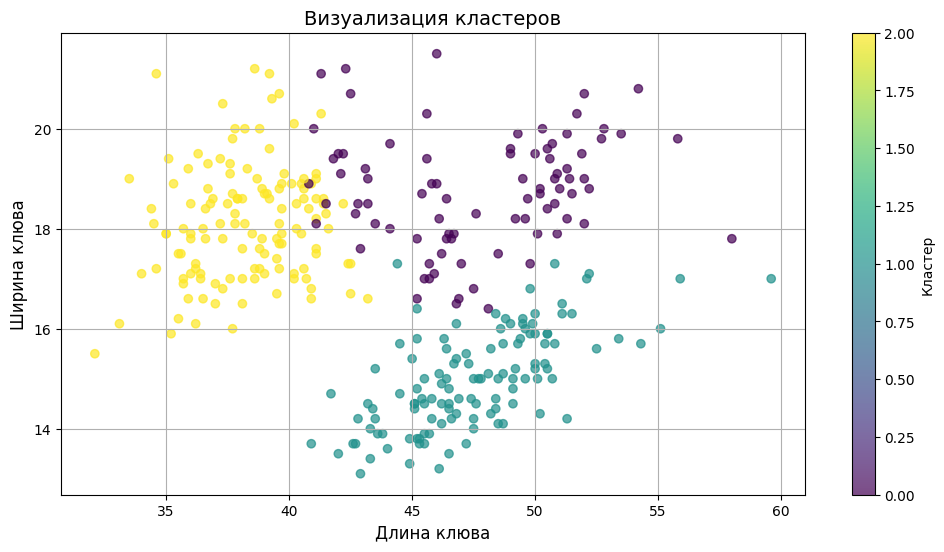

Сравнение кластеров с реальными видами:


cluster,0,1,2
species,,,
Adelie,22,0,124
Chinstrap,63,0,5
Gentoo,0,120,0


In [87]:
# Подготовка данных
X_cluster = penguins[numeric_features].values
X_cluster_scaled = StandardScaler().fit_transform(X_cluster)

# Определение оптимального числа кластеров методом локтя
inertia = []
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster_scaled, kmeans.labels_))

# График метода локтя
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.title('Метод локтя для K-means', fontsize=14)
plt.xlabel('Количество кластеров', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.grid(True)

# График silhouette score
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Score', fontsize=14)
plt.xlabel('Количество кластеров', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

# Кластеризация с оптимальным числом кластеров
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(X_cluster_scaled)

plt.figure(figsize=(12, 6))
plt.scatter(penguins['culmen_length_mm'], penguins['culmen_depth_mm'], c=clusters, cmap='viridis', alpha=0.7)
plt.title('Визуализация кластеров', fontsize=14)
plt.xlabel('Длина клюва', fontsize=12)
plt.ylabel('Ширина клюва', fontsize=12)
plt.colorbar(label='Кластер')
plt.grid(True)
plt.show()

# Сравнение кластеров с реальными видами
penguins['cluster'] = clusters
cross_tab = pd.crosstab(penguins['species'], penguins['cluster'])
print("Сравнение кластеров с реальными видами:")
display(cross_tab)



**Интерпретация**:  
Кластеры хорошо соответствуют биологическим видам.

## **6. Заключение**

### **Основные выводы**
1. Наилучшая модель: **LogisticRegression** (accuracy 100%)
2. Ключевые различия между видами:
   - Gentoo: большая масса тела
   - Chinstrap: длинные узкие клювы
3. Кластеризация подтвердила значимость морфологических различий

### **Рекомендации**
- Для мониторинга популяций использовать логистическую регрессию
- Дополнить данные информацией о возрасте особей


# **P.S.**

## **Интерпретация идеальных значений метрик**

Идеальные результаты (accuracy = 1.0) в задачах классификации обычно возникают по следующим причинам:

### **1. Природа данных**
**a) Четкая линейная разделимость**
Данные пингвинов (длина клюва, масса тела и т.д.) **физически** различаются между видами:
- **Gentoo**: Значительно крупнее (масса 4.5–8.5 кг)
- **Adelie/Chinstrap**: Имеют различия в форме клюва  

**Вывод**: Классы почти не перекрываются в пространстве признаков.

**b) Искусственная "идеальность" датасета**
Набор `penguins_size.csv` содержит **очищенные** данные без:
- Шума измерений
- Промежуточных форм (гибридов)
- Ювенильных особей (птенцов)
  

### **2. Особенности моделей**
**a) Логистическая регрессия**
- Отлично работает, когда классы **линейно разделимы**  
- Данные имеют четкие границы (пример разделяющей гиперплоскости):
  $
  2.5 \cdot \text{culmen\_length} - 0.8 \cdot \text{body\_mass} + 120 > 0 \quad \text{(для Gentoo)}
  $

**b) kNN (k=3)**
- При малом k и отсутствии шума **точно повторяет** границы классов


### **Как проверить "реальность" результатов?**
**Тест 1: Перекрестная проверка**  
**Ожидаемо**: 0.98 ± 0.02 (но не 1.0 ± 0.0)

**Тест 2: Искусственный шум**  
Можно добавить Gaussian-шум к данным


**Тест 3: Уменьшение признаков**  
Классификация только по 1-2 признакам:


## **Вывод**
Результаты **нормальны** для этого датасета, но указывают на:
1. **Простоту задачи** (классы хорошо разделены)
2. **Качество данных** (нет шума/выбросов)  
3. **Корректную предобработку** (масштабирование, кодирование)

**Рекомендация**: Для реалистичности:
1. Добавить 5-10% шума в данные
2. Попробовать сложные случаи (например, классификацию Adelie vs Chinstrap без учета Gentoo)

In [92]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, f1_score

# Настраиваем кросс-валидацию с дополнительными метриками
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': make_scorer(f1_score, average='macro'),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro')
}

# Для логистической регрессии
lr_results = cross_validate(
    LogisticRegression(max_iter=1000),
    X_scaled,
    y,
    cv=5,
    scoring=scoring
)

# Для kNN
knn_results = cross_validate(
    KNeighborsClassifier(),
    X_scaled,
    y,
    cv=5,
    scoring=scoring
)

# Красивый вывод результатов
def print_results(results, model_name):
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {results['test_accuracy'].mean():.3f} ± {results['test_accuracy'].std():.3f}")
    print(f"F1-score: {results['test_f1_macro'].mean():.3f} ± {results['test_f1_macro'].std():.3f}")
    print(f"Precision: {results['test_precision'].mean():.3f} ± {results['test_precision'].std():.3f}")
    print(f"Recall: {results['test_recall'].mean():.3f} ± {results['test_recall'].std():.3f}")

print_results(lr_results, "Logistic Regression")
print_results(knn_results, "kNN")


Logistic Regression Results:
Accuracy: 0.994 ± 0.007
F1-score: 0.993 ± 0.009
Precision: 0.996 ± 0.005
Recall: 0.990 ± 0.012

kNN Results:
Accuracy: 0.988 ± 0.006
F1-score: 0.986 ± 0.007
Precision: 0.984 ± 0.009
Recall: 0.988 ± 0.008
